In [1]:
import cu_rsc as cr
cr.setup_tables()
import RSC_sim
import numpy as np
import cupy as cp
import cupyx
import matplotlib.pyplot as plt

c:\Users\LyuQi\anaconda3\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
M_dev = cr.load_m_table_device()        # upload to GPU
res   = cr.resources_from_config(M_dev)

In [3]:
original_cpu = RSC_sim.get_original_sequence()
seq_cpu = original_cpu[0]*10 + original_cpu[1]*5 + original_cpu[2]*5 + original_cpu[3]*10 + original_cpu[4]*10

In [4]:
original_gpu = cr.get_original_sequences_gpu()  # list/tuple of cp.ndarray blocks

# Repeat each block along the first axis, then concatenate in order
blocks = [
    cp.tile(original_gpu[0], (10, 1)),  # repeat 10 times
    cp.tile(original_gpu[1], (5,  1)),  # repeat 5 times
    cp.tile(original_gpu[2], (5,  1)),  # repeat 5 times
    cp.tile(original_gpu[3], (10, 1)),  # repeat 10 times
    cp.tile(original_gpu[4], (10, 1)),  # repeat 10 times
]

seq_gpu = cp.concatenate(blocks, axis=0)

In [5]:
temp = [25e-6, 25e-6, 25e-6]
def run_cpu(mols_cpu_num, seq_cpu):
    # Adjust max_workers to your machine; user sample uses 16.
    mols_cpu = RSC_sim.initialize_thermal(temp, mols_cpu_num)
    RSC_sim.apply_raman_sequence(mols_cpu, seq_cpu, max_workers=16)

def run_gpu(mols_gpu_num, seq_gpu, res, K_max=30):
    mols_gpu = cr.build_thermal_molecules_gpu(mols_gpu_num, temp)
    cr.raman_cool_with_pumping(mols_gpu, seq_gpu, res, K_max=K_max)
    del mols_gpu

In [6]:
def bench_func_with_cupy_benchmark(fn, *args, n_repeat=5, n_warmup=None, **kwargs):
    """
    Use cupyx.profiler.benchmark to benchmark a callable (CPU or GPU).
    Returns (mean, std) in seconds.
    - For GPU work, uses GPU times (device-synchronized).
    - For CPU-only work, falls back to CPU times.
    """
    if n_warmup is None:
        n_warmup = max(1, n_repeat // 5)

    # Warmup (important for JIT / memory allocation)
    fn(*args, **kwargs)

    res = cupyx.profiler.benchmark(
        fn, args=args, kwargs=kwargs, n_repeat=n_repeat, n_warmup=n_warmup
    )

    # Safely select the correct timing array
    times = None
    if hasattr(res, "gpu_times") and res.gpu_times is not None and len(res.gpu_times) > 0:
        times = np.asarray(res.gpu_times, dtype=float)
    elif hasattr(res, "cpu_times") and res.cpu_times is not None and len(res.cpu_times) > 0:
        times = np.asarray(res.cpu_times, dtype=float)
    elif hasattr(res, "times") and res.times is not None and len(res.times) > 0:
        times = np.asarray(res.times, dtype=float)
    else:
        raise RuntimeError("cupyx.profiler.benchmark did not return valid timing arrays.")

    mean_s = float(times.mean())
    std_s = float(times.std(ddof=1) if times.size > 1 else 0.0)
    return mean_s, std_s

In [7]:
temp = [25e-6, 25e-6, 25e-6]


# Molecule counts (log spaced)
cpu_sizes = np.unique(np.logspace(2, 4, num=7, base=10)).astype(int)   # 1e2 .. 1e4
gpu_sizes = np.unique(np.logspace(2, 5, num=10, base=10)).astype(int)  # 1e2 .. 1e5


In [ ]:
# ---------------- CPU sweep ----------------
cpu_means, cpu_stds = [], []
for n in cpu_sizes:
    mean_s, std_s = bench_func_with_cupy_benchmark(run_cpu, n, seq_cpu, n_repeat=5)
    cpu_means.append(mean_s)
    cpu_stds.append(std_s)
    print(f"CPU n={n}: {mean_s:.4f}s ± {std_s:.4f}s")


Applying pulses to molecules: 100%|██████████| 100/100 [00:14<00:00,  6.91it/s]


CPU n=100: 16.0428s ± 0.6736s


Applying pulses to molecules: 100%|██████████| 215/215 [00:15<00:00, 13.66it/s]


CPU n=215: 19.0339s ± 1.0707s


Applying pulses to molecules: 100%|██████████| 464/464 [00:25<00:00, 18.00it/s]


CPU n=464: 28.9747s ± 1.2758s


Applying pulses to molecules: 100%|██████████| 1000/1000 [00:45<00:00, 21.92it/s]


CPU n=1000: 48.4503s ± 0.9541s


Applying pulses to molecules: 100%|██████████| 2154/2154 [01:21<00:00, 26.56it/s]


CPU n=2154: 87.8810s ± 1.9590s


Applying pulses to molecules: 100%|██████████| 4641/4641 [02:42<00:00, 28.54it/s] 


CPU n=4641: 170.8117s ± 2.0641s


Applying pulses to molecules: 100%|██████████| 10000/10000 [05:41<00:00, 29.25it/s]


CPU n=10000: 349.2925s ± 2.7447s


In [20]:
# ---------------- CPU sweep ----------------
cpu_sizes = [21544]
for n in cpu_sizes:
    mean_s, std_s = bench_func_with_cupy_benchmark(run_cpu, n, seq_cpu, n_repeat=1)
    cpu_means.append(mean_s)
    cpu_stds.append(std_s)
    print(f"CPU n={n}: {mean_s:.4f}s ± {std_s:.4f}s")


Applying pulses to molecules: 100%|██████████| 21544/21544 [11:59<00:00, 29.95it/s]


CPU n=21544: 733.6793s ± 0.0000s


In [13]:

gpu_means, gpu_stds = [], []
# ---------------- GPU sweep ----------------
# Memory pool helps avoid OOM and gets consistent timings
mpool = cp.get_default_memory_pool()
for n in gpu_sizes:
    # Pre-synchronize before timing
    cp.cuda.Device().synchronize()

    mean_s, std_s = bench_func_with_cupy_benchmark(run_gpu, n, seq_gpu, res, K_max=30, n_repeat=5)
    gpu_means.append(mean_s)
    gpu_stds.append(std_s)
    print(f"GPU n={n:>6}: mean={mean_s:.4f}s  std={std_s:.4f}s")

    cp.cuda.Device().synchronize()
    mpool.free_all_blocks()


GPU n=   100: mean=17.3766s  std=0.7963s
GPU n=   215: mean=20.6760s  std=0.5489s
GPU n=   464: mean=25.2405s  std=0.7507s
GPU n=  1000: mean=31.7108s  std=2.2647s
GPU n=  2154: mean=36.4431s  std=1.0089s
GPU n=  4641: mean=44.8696s  std=0.7739s
GPU n= 10000: mean=70.7676s  std=0.6559s
GPU n= 21544: mean=128.3942s  std=1.2938s
GPU n= 46415: mean=259.5288s  std=1.4782s
GPU n=100000: mean=563.9746s  std=4.5748s


In [27]:
n_plot = np.concatenate((np.unique(np.logspace(2, 4, num=7, base=10)).astype(int), np.array(cpu_sizes)))

In [ ]:
# ---------------- CPU sweep ----------------
cpu_sizes = [10, 50]
n_plot = np.concatenate((n_plot, cpu_sizes))
for n in cpu_sizes:
    mean_s, std_s = bench_func_with_cupy_benchmark(run_cpu, n, seq_cpu, n_repeat=5)
    cpu_means.append(mean_s)
    cpu_stds.append(std_s)
    print(f"CPU n={n}: {mean_s:.4f}s ± {std_s:.4f}s")


Applying pulses to molecules: 100%|██████████| 10/10 [00:05<00:00,  1.97it/s]


CPU n=10: 6.2707s ± 0.1858s


Applying pulses to molecules: 100%|██████████| 50/50 [00:14<00:00,  3.51it/s]


CPU n=50: 17.6484s ± 0.5113s


In [41]:
# ---------------- CPU sweep ----------------
scan = [10, 50]
gpu_sizes = np.concatenate((gpu_sizes, scan))
for n in scan:
    # Pre-synchronize before timing
    cp.cuda.Device().synchronize()

    mean_s, std_s = bench_func_with_cupy_benchmark(run_gpu, n, seq_gpu, res, K_max=30, n_repeat=5)
    gpu_means.append(mean_s)
    gpu_stds.append(std_s)
    print(f"GPU n={n:>6}: mean={mean_s:.4f}s  std={std_s:.4f}s")

    cp.cuda.Device().synchronize()
    mpool.free_all_blocks()


GPU n=    10: mean=5.7640s  std=1.2959s
GPU n=    50: mean=12.1222s  std=0.8422s


In [43]:
gpu_sizes


array([   100,    215,    464,   1000,   2154,   4641,  10000,  21544,
        46415, 100000,     10,     50])

In [44]:
n_plot

array([  100,   215,   464,  1000,  2154,  4641, 10000, 21544,    10,
          50])

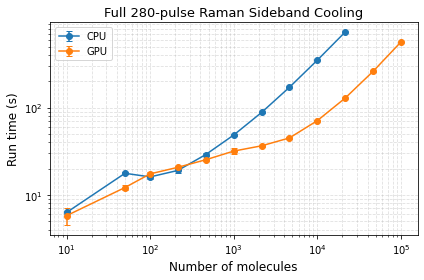

In [47]:
import matplotlib.ticker as ticker
plt.figure()
ind_cpu = np.argsort(n_plot)
plt.errorbar(np.array(n_plot)[ind_cpu], 
             np.array(cpu_means)[ind_cpu], 
             yerr=np.array(cpu_stds)[ind_cpu], 
             fmt='o-', capsize=3, label='CPU')
ind_gpu = np.argsort(gpu_sizes)
plt.errorbar(np.array(gpu_sizes)[ind_gpu], 
             np.array(gpu_means)[ind_gpu], 
             yerr=np.array(gpu_stds)[ind_gpu], 
             fmt='o-', capsize=3, label='GPU')
plt.xscale('log')
plt.yscale('log')
ax = plt.gca()
ax.yaxis.set_major_locator(ticker.LogLocator(base=10.0, numticks=15))
ax.yaxis.set_minor_locator(ticker.LogLocator(base=10.0, subs=np.arange(2, 10)*0.1, numticks=100))
ax.yaxis.set_minor_formatter(ticker.NullFormatter())

plt.xlabel('Number of molecules', fontsize=12)
plt.ylabel('Run time (s)', fontsize=12)
plt.title("Full 280-pulse Raman Sideband Cooling", fontsize=13)

plt.legend()
plt.grid(True, which='both', ls='--', alpha=0.4)
plt.tight_layout()
plt.show()

In [46]:
np.savez(
    "Full_benchmark.npz", 
    cpu_sizes=n_plot, 
    cpu_means=cpu_means,
    cpu_stds=cpu_stds,
    gpu_sizes=gpu_sizes,
    gpu_means=gpu_means,
    gpu_stds=gpu_stds)